<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/12-rnn-alternatives/01_torchtext_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Torch text basic

Recurrent neural networks—in particular, LSTMs—have been used for classifying and
working with sequence problems for over two decades. While they have long been
reliable tools for the task, they have several undesirable properties. 

* RNNs are just plain 
* they do not scale well with more layers or with more GPUs

With skip connections and residual
layers, we have learned about many ways to get fully connected and convolutional
networks to train with more layers to get better results. 

But RNNs just do not seem to
like being deep. You can add more layers and skip connections, but they do not show
the same degree of benefits as improved accuracy.

So, we look at some methods that can help us with one or both of these
problems.

* we tackle the slowness of RNNs by violating our prior beliefs.
* we look at a different way of representing the sequential component of our data to augment these faster alternatives and regain some of our accuracy.
* Finally, we learn about transformers.



##Setup

In [ ]:
!pip install portalocker

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab

from torchtext.datasets import AG_NEWS

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

from idlmam import train_network, Flatten, weight_reset, View, set_seed
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore, ApplyAttention, getMaskByFill

<ipython-input-1-07d797895a22>:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

<ipython-input-2-024163930d81>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [3]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
import warnings
warnings.filterwarnings("ignore")

##AG News dataset

In [6]:
# let’s quickly load AG_NEWS dataset
train_iter, test_iter = AG_NEWS(root="./data", split=("train", "test"))

train_dataset = list(train_iter)
test_dataset = list(test_iter)

In [7]:
print(train_dataset[0])

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


In [8]:
# tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']
tokenizer = get_tokenizer("basic_english") # we will be fine with the default english style tokenizer

# we need to create a vocabulary of all the words in the training set
counter = Counter()
for (label, line) in train_dataset:
  # count the number of unique tokens we see and how often we see them (e.g., we will see "the" a lot, but "sasquatch" maybe once or not at all.)
  counter.update(tokenizer(line))
# create a vocab object, removing any word that didn't occur at least 10 times, 
# and add special vocab items for unkown, begining of sentance, end of sentance, and "padding"
vocab = vocab(counter, min_freq=10, specials=("<unk>", "<BOS>", "<EOS>", "<PAD>"))
vocab.set_default_index(vocab["<unk>"])

In [11]:
len(vocab)

20647

In [9]:
def text_transform(x):
  # vocab acts like a dictionary, handls unkown tokens.
  # We can make it pre- and post-pend with the start and end markers, respectively.
  return [vocab["<BOS>"]] + [vocab[token] for token in tokenizer(x)] + [vocab["<EOS>"]]

def label_transform(y):
  # labes are originally [1, 2, 3, 4] but we need them as [0, 1, 2, 3] 
  return y - 1

In [10]:
train_dataset[0][1]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [10]:
# let's transform the first data point's text into a list of tokens
print(text_transform(train_dataset[0][1]))

[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 14, 16, 0, 17, 4, 18, 19, 20, 0, 21, 0, 17, 22, 23, 24, 25, 6, 2]


In [ ]:
# To make training faster, let’s limit ourselves to sentences that contain six or fewer words.
short_subset = []
MAX_LEN = 6

for (s, t) in all_data:
  if max(len(s.split(" ")), len(t.split(" "))) <= MAX_LEN:
    short_subset.append((s, t))
print(f"Using {len(short_subset)} / {len(all_data)}")

Using 66251 / 135842


In [ ]:
# let's defines SOS, EOS, and padding markers and creates a dictionary word2indx to create the mapping 
# and an inverted dictionary indx2word so that we can look at our results more easily when we are done
SOS_token = "<SOS>"  # START_OF_SENTANCE_TOKEN
EOS_token = "<EOS>"  # END_OF_SENTANCE_TOKEN
PAD_token = "_PADDING_"

word2index = {PAD_token: 0, SOS_token: 1, EOS_token: 2}
for s, t in short_subset:
  for sentance in (s, t):
    for word in sentance.split(" "):
      if word not in word2index:
        word2index[word] = len(word2index)
print(f"Size of Vocab: {len(word2index)}")

# build the inverted dict for looking at the outputs later
index2word = {}
for word, index in word2index.items():
  index2word[index] = word

Size of Vocab: 24577


In [ ]:
class TranslationDataset(Dataset):
  """
  Takes a dataset with tuples of strings (x, y) and converts them to tuples of int64 tensors. 
  This makes it easy to encode Seq2Seq problems.
  
  Strings in the input and output targets will be broken up by spaces
  """
  def __init__(self, lang_pairs, word2index):
    """
    lang_pairs: a List[Tuple[String,String]] containing the source,target pairs for a Seq2Seq problem. 
    word2indx: a Map[String,Int] that converts each word in an input string into a unique ID.
    """
    self.lang_pairs = lang_pairs 
    self.word2index = word2index 

  def __len__(self):
    return len(self.lang_pairs)

  def __getitem__(self, idx):
    x, y = self.lang_pairs[idx]
    x = SOS_token + " " + x + " " + EOS_token
    y = y + " " + EOS_token
    
    # convert to lists of integers
    x = [self.word2index[w] for w in x.split(" ")]
    y = [self.word2index[w] for w in y.split(" ")]

    x = torch.tensor(x, dtype=torch.int64)
    y = torch.tensor(y, dtype=torch.int64)

    return x, y

In [ ]:
big_dataset = TranslationDataset(short_subset, word2index)

In [ ]:
# let's define a collate_fn function to create one larger batch from the inputs that are different lengths
def pad_batch(batch):
  """Pad items in the batch to the length of the longest item in the batch"""
  """
  We actually have two different maxiumum lengths! 
  The max length of the input sequences, and the max length of the output sequences. 
  So we will determine each seperatly, and only pad the inputs/outputs by the exact amount we need
  """
  max_x = max([i[0].size(0) for i in batch])
  max_y = max([i[1].size(0) for i in batch])

  PAD = word2index[PAD_token]

  # We will use the F.pad function to pad each tensor to the right
  X = [F.pad(i[0], (0, max_x - i[0].size(0)), value=PAD) for i in batch]
  Y = [F.pad(i[1], (0, max_y - i[1].size(0)), value=PAD) for i in batch]

  X, Y = torch.stack(X), torch.stack(Y)
  return (X, Y), Y

In [ ]:
# Want a consistent dataset split
set_seed(42)

B = 128
epochs = 10

train_size = round(len(big_dataset) * 0.9)
test_size = len(big_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(big_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

In [ ]:
# test the data loader
iterator = iter(train_loader)
batch1 = next(iterator)
batch2 = next(iterator)

In [ ]:
batch1[0][0]

tensor([[   1,  254, 2347,  ...,    2,    0,    0],
        [   1,   26,  640,  ...,  243,    2,    0],
        [   1, 5571, 1592,  ...,    0,    0,    0],
        ...,
        [   1,  488,  697,  ...,    0,    0,    0],
        [   1, 1490, 1019,  ...,  188, 1823,    2],
        [   1,  109,  523,  ...,  477,    2,    0]])

In [ ]:
batch2[0][0]

tensor([[    1, 22831, 15966,  ...,   164,     2,     0],
        [    1,  1313,  5788,  ...,   188,  3889,     2],
        [    1,    47,   119,  ...,   243,     2,     0],
        ...,
        [    1,   905,  1287,  ...,     0,     0,     0],
        [    1,   488,  1060,  ...,  1313,  8650,     2],
        [    1,   226,  5133,  ...,   842,     2,     0]])

##Seq2Seq Attention

The attention mechanism can work with both teacher forcing and the autoregressive `t'th` approach and will change how we make predictions about the current word at the step of the RNN.

So rather than have the decoder RNN predict $\hat y_t$, we have it produce
a latent value $\hat z_t$. The value $\hat z_t$ is our context for the attention mechanism.

1. The encoder step learns a useful representation of the input.
2. The decoder step predicts a context for each item of the output.
3. The attention step uses the context to produce an output $\hat x_t$, which is combined with the context $\hat z_t$.
4. The prediction step takes the combined attention/context result and predicts the next token of the sequence.



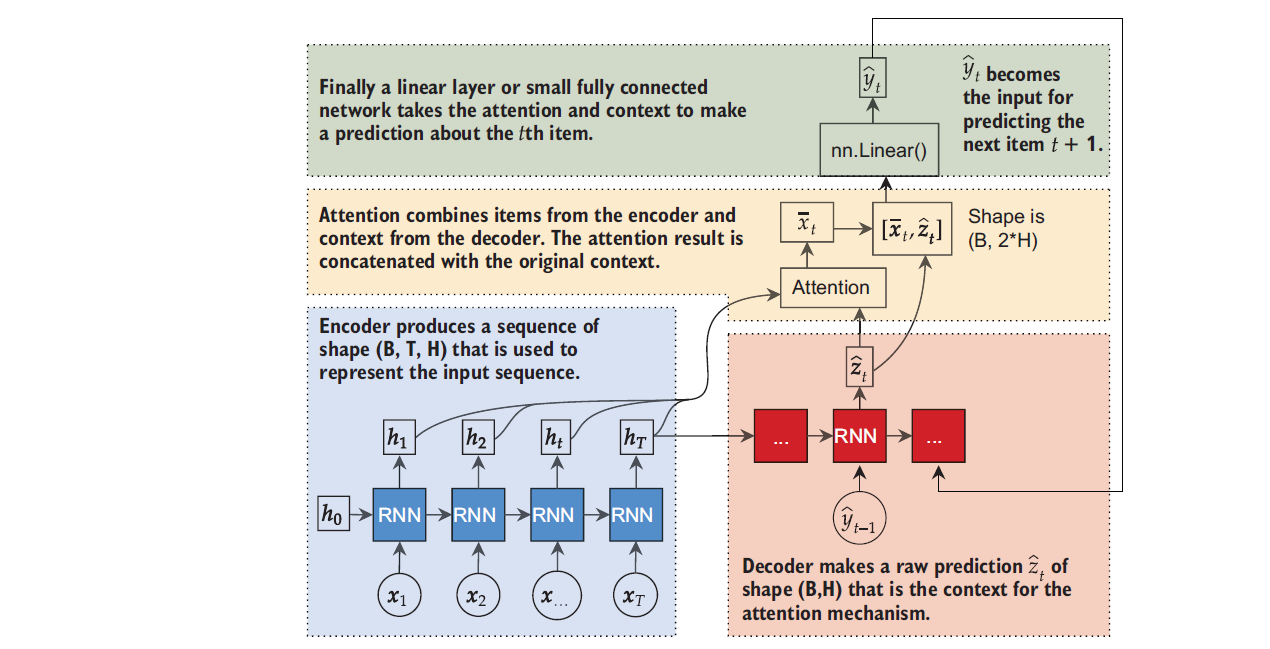

In [ ]:
class Seq2SeqAttention(nn.Module):

  def __init__(self, num_embeddings, embedding_size, hidden_size, padding_idx=None, layers=1, max_decode_length=20):
    super(Seq2SeqAttention, self).__init__()

    self.padding_idx = padding_idx 
    self.hidden_size = hidden_size
    self.embedding_layer = nn.Embedding(num_embeddings, embedding_size, padding_idx=padding_idx)

    """
    We set the hidden size to half the intended length, because we will make the encoder bi-directional.
    That means we will get 2 hidden state representations which we will concatinate together, giving us the desired size!
    """
    self.encoding_layers = nn.GRU(input_size=embedding_size, hidden_size=hidden_size // 2, num_layers=layers, bidirectional=True)

    # But decoder will be uni-directionall, and we need to use CRUCells so that we can do the decoding one step at a time
    self.decoding_layers = nn.ModuleList([nn.GRUCell(embedding_size, hidden_size)] + [nn.GRUCell(hidden_size, hidden_size) for i in range(layers - 1)])
    self.score_net = DotScore(hidden_size)

    """
    predict_word will be a small fully connected network that we use to convert the  result of the attention mechanism 
    and the local context into a prediction for the next word
    """
    self.predict_word = nn.Sequential(
      nn.Linear(2 * hidden_size, hidden_size),
      nn.LeakyReLU(),
      nn.LayerNorm(hidden_size),

      nn.Linear(hidden_size, hidden_size),
      nn.LeakyReLU(),
      nn.LayerNorm(hidden_size),

      nn.Linear(hidden_size, num_embeddings)
    )

    self.max_decoding_length = max_decode_length
    self.apply_attention = ApplyAttention()

  def forward(self, input):
    ###################################################
    # Step-1 : Preparation, embedding, and masking block
    ###################################################
    # Input should be (B, T) or ((B, T), (B, T')) depending on whether we are in testing or training mode
    if isinstance(input, tuple):
      input, target = input
    else:
      target = None

    # What is the batch size?
    B = input.size(0)
    # What is the max number of input time steps?
    T = input.size(1)
    # embd all of the input values (B, T, D)
    x = self.embedding_layer(input)

    # grab the device that the model currently resides on we will need this later
    device = x.device 

    # We will use the mask to figure out how long each input sequence is
    mask = getMaskByFill(x)
    seq_lengths = mask.sum(dim=1).view(-1) # shape (B), containing the # of non-zero values

    ###################################################
    #   Step-2 : Encoding block
    ###################################################
    # the sequence lengths will be used to create a packed input for the encoder RNN
    x_packed = pack_padded_sequence(x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
    h_encoded, h_last = self.encoding_layers(x_packed)
    h_encoded, _ = pad_packed_sequence(h_encoded)  # (B, T, 2, D//2) , b/c its bidirectional
    # (B, T, D), Now h_encoded is the result of running the encoder RNN on the input!
    h_encoded = h_encoded.view(B, T, -1)

    # Getting the last hidden state is a little trickier
    # first the output gets reshaped as (num_layers, directions, batch_size, hidden_size)
    # and then we grab the last index in the first dimension, because we want the last layer's output
    hidden_size = h_encoded.size(2)
    h_last = h_last.view(-1, 2, B, hidden_size // 2)[-1, :, :, :]  # The shape is now (2, B, D/2)
    # now we will reorder to (B, 2, D/2), and flatten the last two dimensions down to (B, D)
    h_last = h_last.permute(1, 0, 2).reshape(B, -1)
    # End of Encoding portion. 
    # h_encoded now contains the representation of the input data!
    # h_last has the final ouputs of the RNN, to use as the initial input state for the decoder

    ###################################################
    #   Step-3 : Decoding block
    ###################################################
    # The first input to the decoder will be the output of the last encoder step decoder_input = h_last
    h_prevs = [h_last for l in range(len(self.decoding_layers))]  # new hidden states for decoders

    # We will save all the attention mechanism results for visualization
    all_attentions = []
    all_predictions = []

    # Grab the last item from the input (which should be an EOS marker) as the first input for the decoder
    # We could also hard-code the SOS marker instead
    # we need to gathers the specified indices along the specified axis (1)
    decoder_input = self.embedding_layer(input.gather(1, seq_lengths.view(-1, 1) - 1).flatten())

    # How many decoding steps should we do?
    steps = min(self.max_decoding_length, T)
    # If we are training, the target values tells us exactly how many steps to take
    if target is not None:
      steps = target.size(1)  # We know the exact decode length!

    ###################################################
    #   Step-4 : Compute the context and attention block
    ###################################################
    # Do we use teacher forcing (true) or auto-regressive (false)
    teacher_forcing = np.random.choice((True, False))
    for t in range(steps):
      x_in = decoder_input  # (B, D)
      for l in range(len(self.decoding_layers)):
        h_prev = h_prevs[l]
        h = h_prevs[l]
        h = self.decoding_layers[l](x_in, h_prev)

        h_prevs[l] = h
        x_in = h
      
      # (B, D), we now have the hidden state for the decoder at this time step
      h_decoder = x_in

      # This is the attention mechanism, lets look at all the previous encoded states and see which look relevant
      scores = self.score_net(h_encoded, h_decoder)  # (B, T, 1)
      context, weights = self.apply_attention(h_encoded, scores, mask=mask)  # (B, D) for x and (B, T) for alpha

      # save the attention weights for visualization later
      all_attentions.append(weights.detach())  # want to compute anything with them anymore, just want to save their values for visualizations

      ###################################################
      #   Step-5 : Compute prediction block
      ###################################################
      # Now lets compute the final representation by concatinating the attention result and the initial context
      word_pred = torch.cat((context, h_decoder), dim=1)  # (B, D) + (B, D)  -> (B, 2*D)
      # and get a prediction about what the next token is by pushing it through a small fully-connected network
      word_pred = self.predict_word(word_pred)            # (B, 2*D) -> (B, V)
      all_predictions.append(word_pred)

      ###################################################
      #   Step-6 : Select decoder's next input block
      ###################################################
      # Now we have $\hat{y}_t$! we need to select the input for the next time step. 
      # We use torch.no_grad() because the gradient will carry through the hidden states of the RNN, not the input tokens
      with torch.no_grad():
        if self.training:
          if target is not None and teacher_forcing:
            # We have the target and selected teacher forcing, so use the correct next answer
            next_words = target[:, t].squeeze()
          else:
            # Sample the next token based on the predictions made
            next_words = torch.multinomial(F.softmax(word_pred, dim=1), 1)[:, -1]
        else:
          # we are trying to make an actual prediction, so take the most likely word
          # we could improve this by using temperature and sampling method
          next_words = torch.argmax(word_pred, dim=1)

      # We've decided what the next tokens are, we are back to using the gradient calculation 
      # so that the embedding layer is adjusted appropriately during training. 
      decoder_input = self.embedding_layer(next_words.to(device))

    # done decoding!

    if self.training:
      # When training, only the predictions are important
      return torch.stack(all_predictions, dim=1)
    else:
      # When evaluatin, we also want to look at the attention weights
      return torch.stack(all_predictions, dim=1), torch.stack(all_attentions, dim=1).squeeze()

##Training and evaluation

In [ ]:
epochs = 20

seq2seq = Seq2SeqAttention(len(word2index), 64, 256, padding_idx=word2index[PAD_token], layers=3, max_decode_length=MAX_LEN + 2)
for p in seq2seq.parameters():
  p.register_hook(lambda grad: torch.clamp(grad, -10, 10))

In [ ]:
def cross_entropy_loss_on_time(x, y):
  """
  x: output with shape (B, T, V)
  y: labels with shape (B, T')
  """
  if isinstance(x, tuple):
    x, _ = x
  
  # We do not want to compute a loss for items that have been padded out!
  cel = nn.CrossEntropyLoss(ignore_index=word2index[PAD_token])
  T = min(x.size(1), y.size(1))

  loss = 0
  for t in range(T):
    loss += cel(x[:, t, :], y[:, t])
  return loss

In [ ]:
seq2seq_results = train_network(seq2seq, 
                                cross_entropy_loss_on_time,
                                train_loader,
                                epochs=epochs,
                                device=device)

<Axes: xlabel='epoch', ylabel='train loss'>

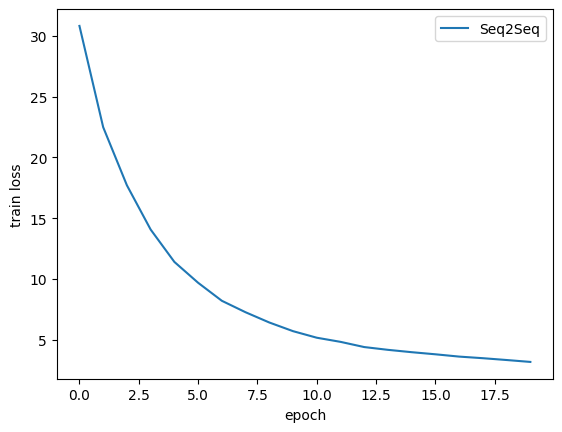

In [ ]:
sns.lineplot(x="epoch", y="train loss", data=seq2seq_results, label="Seq2Seq")

In [ ]:
# let’s quickly put our seq2seq model into evaluation mode that will help us subjectively evaluate the results.
seq2seq = seq2seq.eval().cpu()

def results(index):
  eng_x, french_y = test_dataset[index]

  eng_str = " ".join([index2word[i] for i in eng_x.cpu().numpy()])
  french_str = " ".join([index2word[i] for i in french_y.cpu().numpy()])
  print(f"Input: {eng_str}")
  print(f"Target: {french_str}")

  with torch.no_grad():
    preds, attention = seq2seq(eng_x.unsqueeze(0))
    prob = torch.argmax(preds, dim=2)

  pred_str = " ".join([index2word[i] for i in prob[0, :].cpu().numpy()])
  print(f"Predicted: {pred_str}")

  plot_heatmap(eng_str.split(" "), pred_str.split(" "), attention.T.cpu().numpy())

Input: <SOS> some animals are afraid of fire <EOS>
Target: certains animaux craignent le feu <EOS>
Predicted: certains animaux parlent la feu <EOS> <EOS> <EOS>


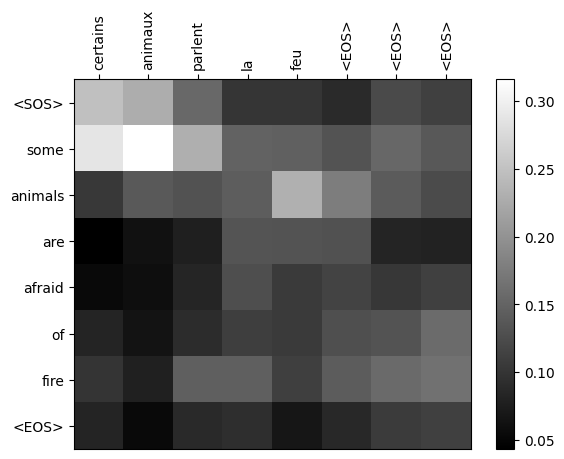

In [ ]:
# Now we can look at some results
results(12)

Input: <SOS> what is the weather like today <EOS>
Target: comment est le temps aujourd'hui <EOS>
Predicted: quel temps fait il aujourd'hui <EOS> <EOS> <EOS>


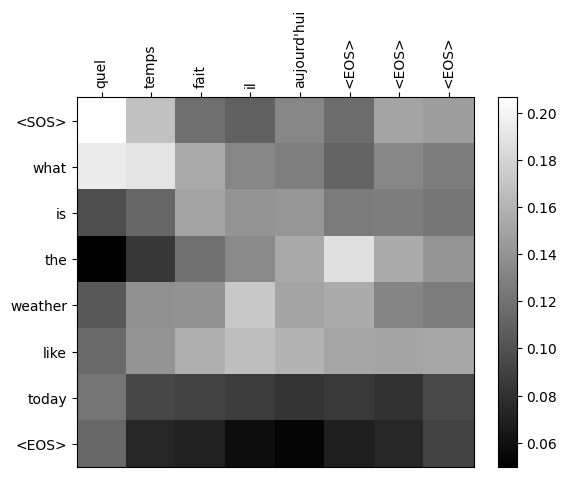

In [ ]:
results(13)

Input: <SOS> no one disagreed <EOS>
Target: personne ne fut en désaccord <EOS>
Predicted: personne n'a été désaccord désaccord


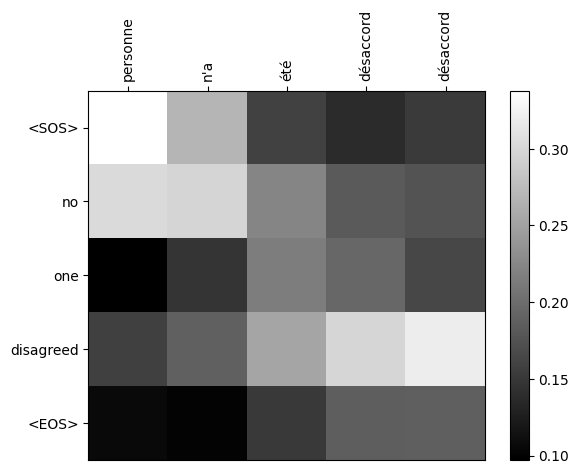

In [ ]:
results(16)

We can also see how we can use the action mechanism to better understand our
model’s results. 

This is something very powerful about attention mechanisms: they give
us a degree of interpretability in our otherwise opaque neural networks.